**1 Import Libraries**

In [255]:
#loading dataset
import pandas as pd
import numpy as np
# data analysis
import random as rnd
import os
import warnings

from operator import add

MEDIUM_SIZE = 10
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
import seaborn as sns
# data preprocessing
from sklearn.preprocessing import StandardScaler
# data splitting
from sklearn.model_selection import train_test_split
# data modeling
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#ensembling
from mlxtend.classifier import StackingCVClassifier
import sklearn

**2 Import Dataset**

In [182]:
df = pd.read_csv('/content/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [183]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
print(f'Dataset contains {df.shape[0]} samples, {df.shape[1] - 1} independent features 1 target continuous variable.')

Dataset contains 303 samples, 13 independent features 1 target continuous variable.


**3 Basic Data Check**

In [184]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
print(df.info())
missing_values = (df.isnull().sum() / len(df)) * 100
print("\nFeatures with missing values: \n", missing_values[missing_values > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None

Features with missing values: 
 Series([], dtype: float64)


Based on the results, all the feartures have balanced data and all the data are numeric. 

In [185]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


All the data seems reasonable and no outlier

In [186]:
print(np.char.center(" Unique values of categorical variables ", 60, fillchar = "*"))
print("\nSex: ", df.sex.unique())
print("Cp: ", sorted(df.cp.unique()))
print("fbs: ", sorted(df.fbs.unique()))
print("restecg: ", sorted(df.restecg.unique()))
print("exang: ", sorted(df.exang.unique()))
print("slope: ", sorted(df.slope.unique()))
print("ca: ", sorted(df.ca.unique()))
print("thal: ", sorted(df.thal.unique()))
print("target: ", sorted(df.target.unique()))

********** Unique values of categorical variables **********

Sex:  [1 0]
Cp:  [0, 1, 2, 3]
fbs:  [0, 1]
restecg:  [0, 1, 2]
exang:  [0, 1]
slope:  [0, 1, 2]
ca:  [0, 1, 2, 3, 4]
thal:  [0, 1, 2, 3]
target:  [0, 1]


* Sex is a nominal variable. 1 - Male, 0 - Famale
* Cp - Chest pain type is a nominal variable, unique values are 0, 1, 2 and 3
* fbs - fasting blood sugar is a binary variable. Value is 1 for (fasting blood sugar) > 120 mg/dl, otherwise 0
* restecg - resting electrocardiographic results - is a nominal variable, unique values are 0, 1 and 2
* exang - exercise induced angina is a binary variable, Value is 1 is induced, 0 if not
* slope - the slope of the peak exercise ST segment is a nominal variable, unique values are 0, 1 and 2
* ca - number of major vessels (0-3) colored by flourosopy is an ordinal variable, values are 0, 1, 2, 3 and 4
* thal - 0 = null; 1 = fixed defect; 2 = normal blood flow, 3 = reversible defect

**4 Detailed Analysis**

In [187]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
def draw_semi_pie_chart(data, column, fig, renamed_index_dict, title):
    default_colors = ['#66b3ff', '#ff9999', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ff6666']
    rnd.shuffle(default_colors)
    ax = df[column].value_counts().rename(index = renamed_index_dict).plot.pie(colors = default_colors, autopct='%1.1f%%', startangle=90, title = title)
    ax.set_ylabel('')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
        
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)

**4.1 Categorical Feature Value Ratio**


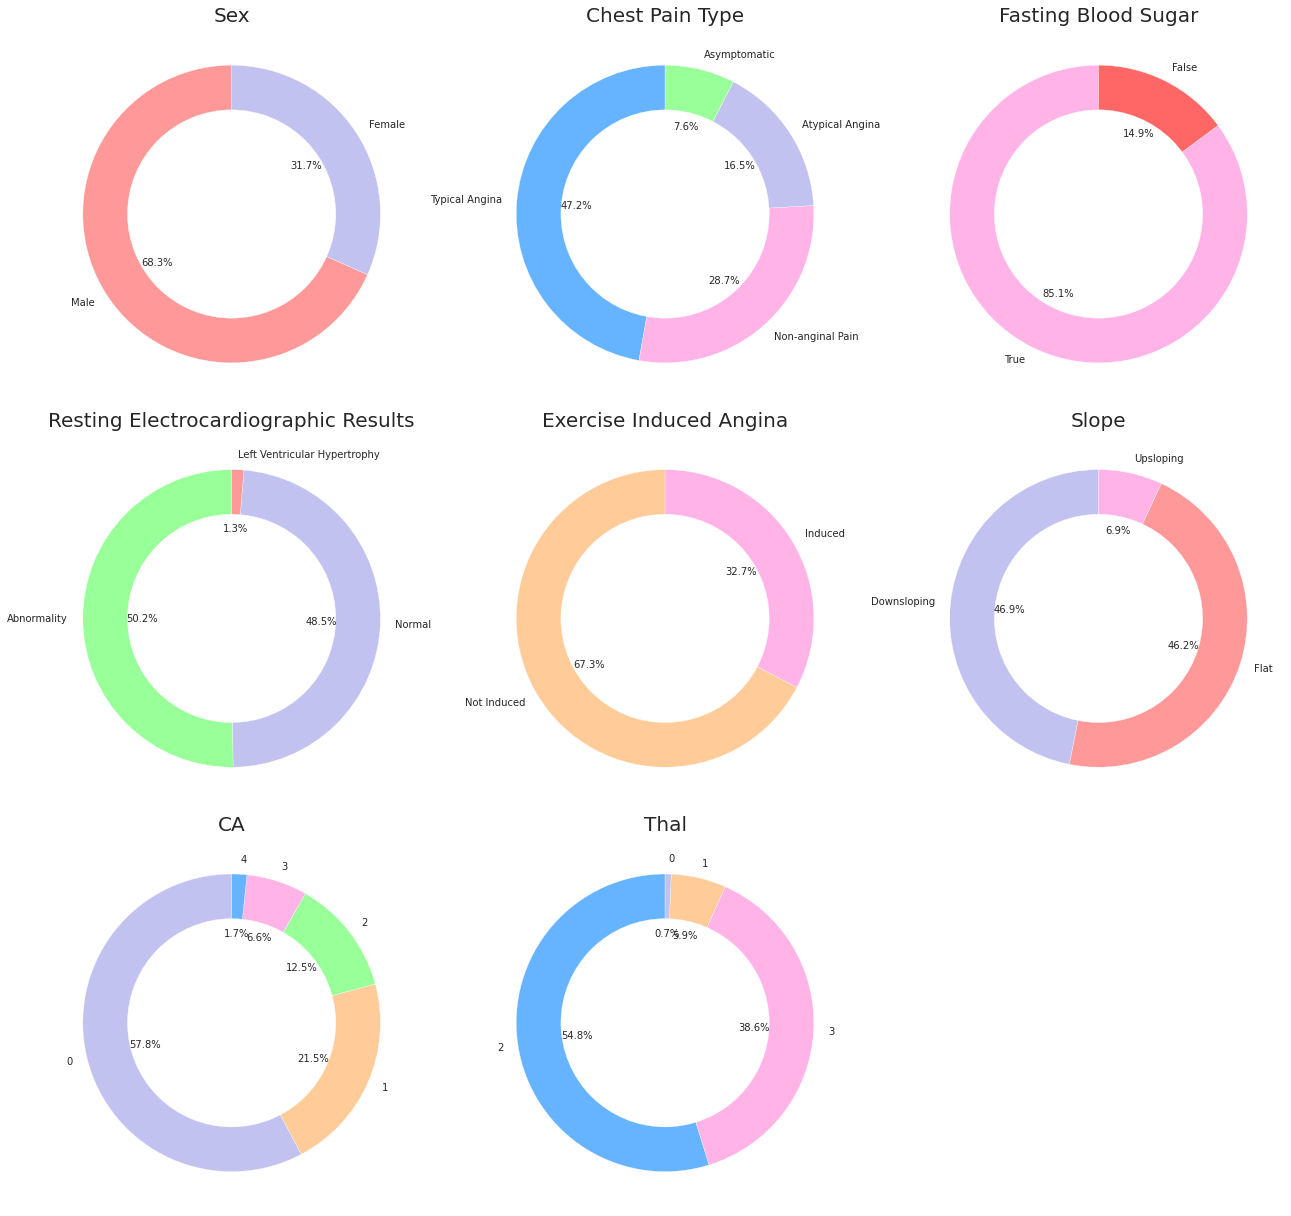

In [188]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
fig = plt.gcf()
fig.set_size_inches(18, 17)
grid_rows = 3
grid_cols = 3

# Draw Sex Pie chart
plt.subplot(grid_rows, grid_cols, 1)
draw_semi_pie_chart(df, 'sex', fig, {0: 'Female', 1: 'Male'}, 'Sex')

# Draw Chest pain type chart
plt.subplot(grid_rows, grid_cols, 2)
draw_semi_pie_chart(df, 'cp', fig, {0:'Typical Angina', 1:'Atypical Angina', 2:'Non-anginal Pain',3:'Asymptomatic'}, 'Chest Pain Type')

# Draw Fasting blood sugar chart
plt.subplot(grid_rows, grid_cols, 3)
draw_semi_pie_chart(df, 'fbs', fig, {0:'True', 1:'False'}, 'Fasting Blood Sugar')

# Draw restecg - resting electrocardiographic results
plt.subplot(grid_rows, grid_cols, 4)
draw_semi_pie_chart(df, 'restecg', fig, {0:'Normal', 1:'Abnormality', 2:'Left Ventricular Hypertrophy'}, 'Resting Electrocardiographic Results')

# Draw exang - exercise induced angina
plt.subplot(grid_rows, grid_cols, 5)
draw_semi_pie_chart(df, 'exang', fig, {0:'Not Induced', 1:'Induced'}, 'Exercise Induced Angina')

# Draw exang - exercise induced angina
plt.subplot(grid_rows, grid_cols, 6)
draw_semi_pie_chart(df, 'slope', fig, {0:'Upsloping', 1:'Flat', 2:'Downsloping'}, 'Slope')

# Draw ca
plt.subplot(grid_rows, grid_cols, 7)
draw_semi_pie_chart(df, 'ca', fig, {0:'0', 1:'1', 2:'2', 3:'3', 4:'4'}, 'CA')

# Draw thal
plt.subplot(grid_rows, grid_cols, 8)
draw_semi_pie_chart(df, 'thal', fig, {0:'0', 1:'1', 2:'2', 3:'3'}, 'Thal')

fig.tight_layout()
plt.show()

* Categorical features are not well balanced in the dataset.
* Dataset contains more male patients than female.
* Typical Angina and Non-Anginal is the top 2 Chest pain type.
* Majority of the patients has Fasting Blood Sugar > 120 mg/dl.
* Left Ventricular Hypertrophy is observed least in Resting Electrocardiographics Results.
* Excersize didn't induce Angina for more than 60% patients.
* Unslopping is least observed in the Slope.
* Least type of CA is 4 and most type is 0
* Most type of Thal is normal blood flow


In [189]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
def create_percent_stacked_barchart(data, title = None, ylabel = None, xlabel = None):
    default_colors = ['#019600', '#3C5F5A', '#219AD8']
    # From raw value to percentage
    totals = data.sum(axis=1)
    bars = ((data.T / totals) * 100).T
    r = list(range(data.index.size))

    # Plot
    barWidth = 0.95
    names = data.index.tolist()
    bottom = [0] * bars.shape[0]

    # Create bars
    color_index = 0
    plots = []
    for bar in bars.columns:
        plots.append(plt.bar(r, bars[bar], bottom=bottom, color=default_colors[color_index], edgecolor='white', width=barWidth))
        bottom = list(map(add, bottom, bars[bar]))
        color_index = 0 if color_index >= len(default_colors) else color_index + 1

    # Custom x axis
    plt.title(title)
    plt.xticks(r, names)
    plt.xlabel(data.index.name if xlabel is None else xlabel)
    plt.ylabel(data.columns.name if ylabel is None else ylabel)
    ax = plt.gca()
        
    y_labels = ax.get_yticks()
    ax.set_yticklabels([str(y) + '%' for y in y_labels])
    
    flat_list = [item for sublist in data.T.values for item in sublist]
    for i, d in zip(ax.patches, flat_list):
        data_label = str(d) + " (" + str(round(i.get_height(), 2)) + "%)"
        ax.text(i.get_x() + 0.45, i.get_y() + 5, data_label, horizontalalignment='center', verticalalignment='center', fontdict = dict(color = 'white', size = 20))

    for item in ([ax.title]):
        item.set_fontsize(27)

    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
    
    legend = ax.legend(plots, bars.columns.tolist(), fancybox=True)
    plt.setp(legend.get_texts(), fontsize='20')

**4.2 Categorical Feature Value Ratio against Target**

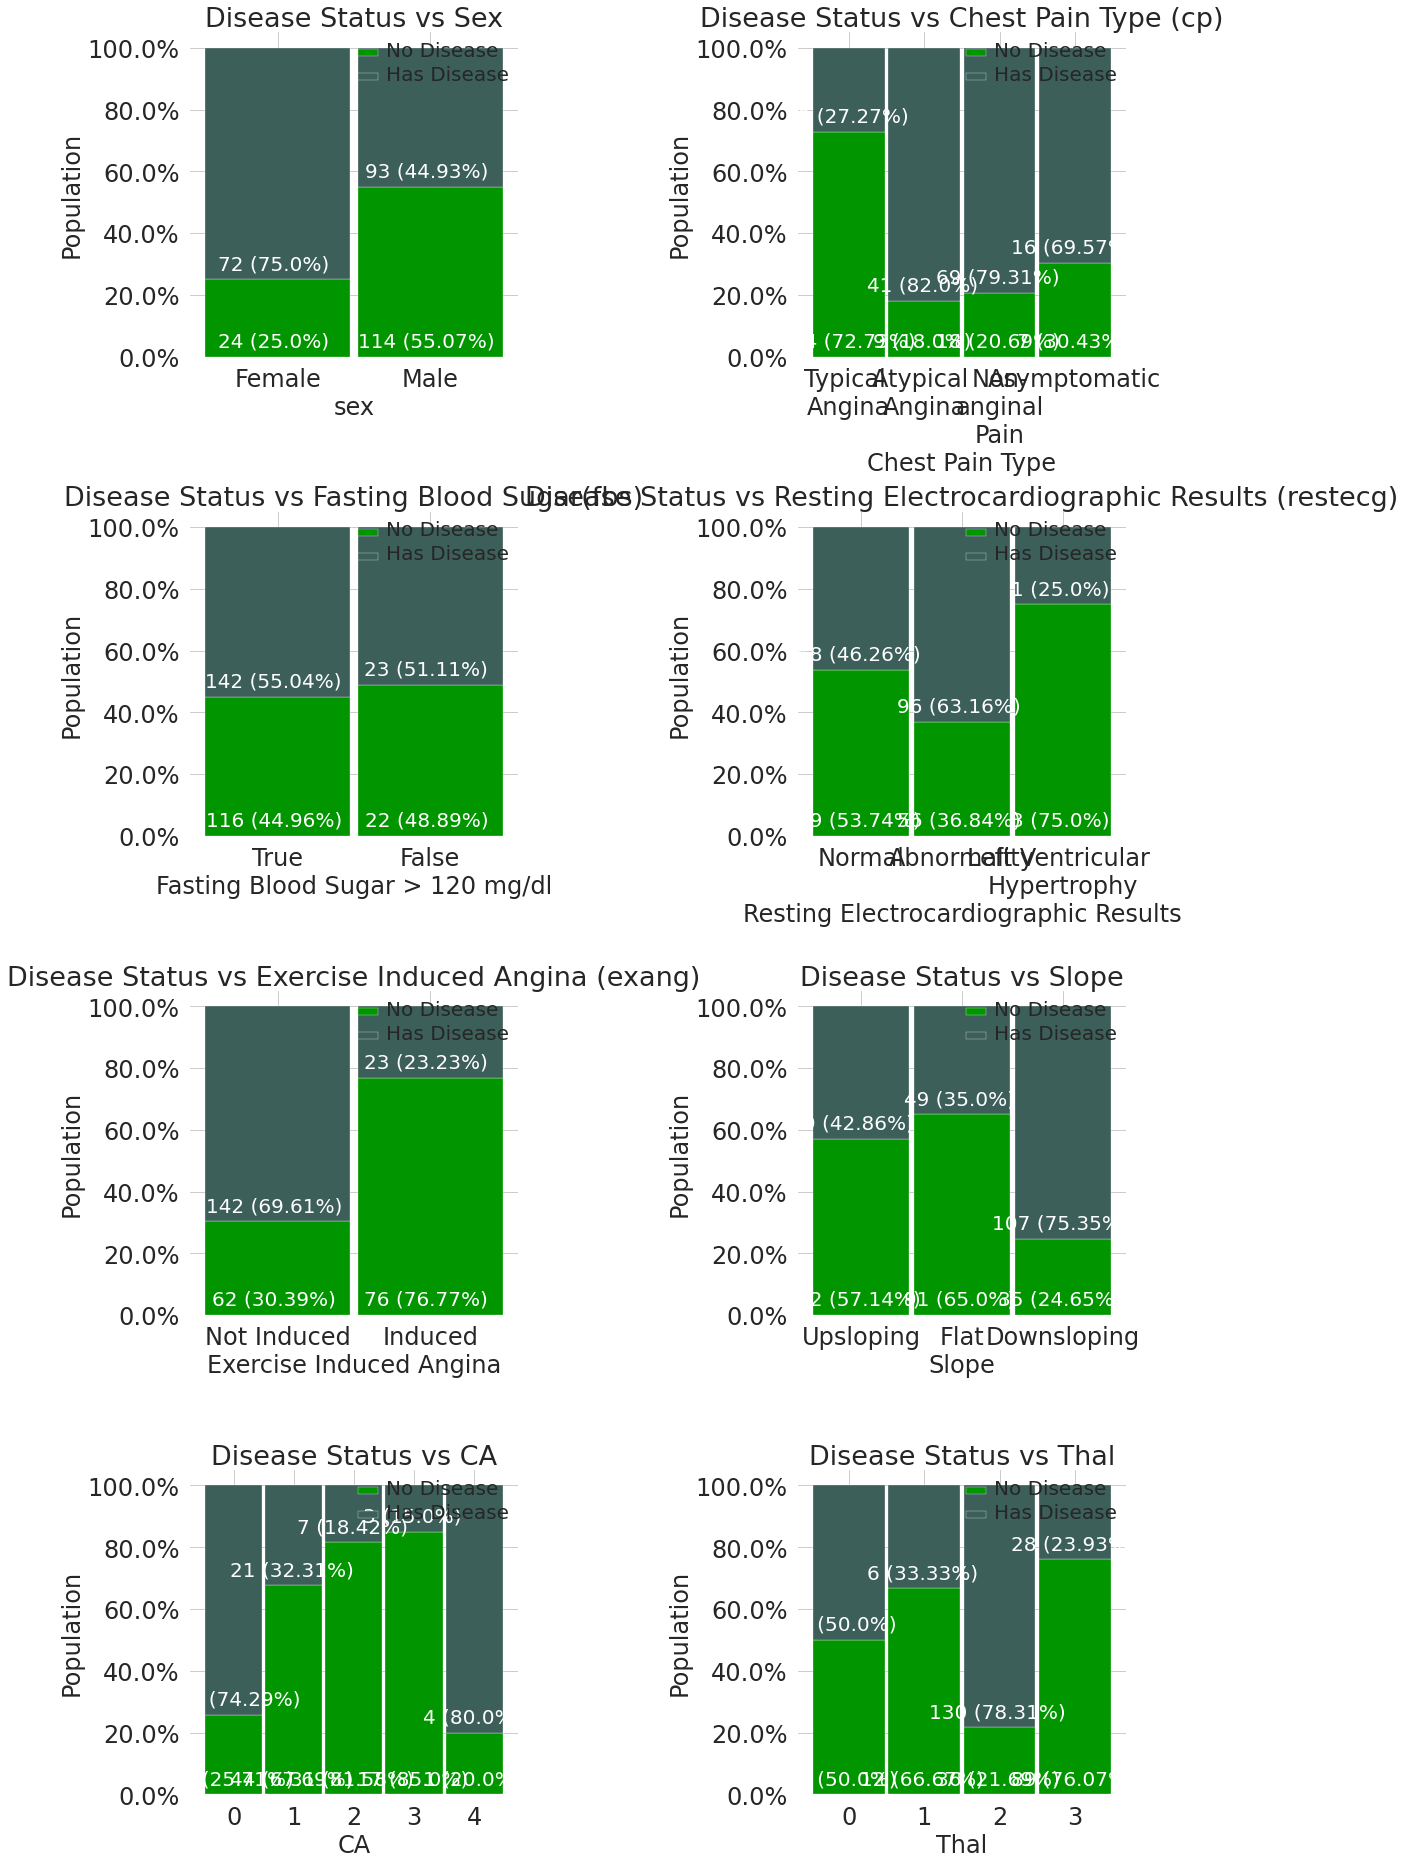

In [190]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
fig = plt.gcf()
fig.set_size_inches(18, 26)
grid_rows = 4
grid_cols = 2
# Draw Disease Status vs Sex chart
plt.subplot(grid_rows, grid_cols, 1)
temp = df[['sex','target']].groupby(['sex','target']).size().unstack('target')
temp.rename(index={0:'Female', 1:'Male'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
create_percent_stacked_barchart(temp, title = 'Disease Status vs Sex', ylabel = 'Population')

# Draw Disease Status vs Chest pain type chart
plt.subplot(grid_rows, grid_cols, 2)
temp = df[['cp','target']].groupby(['cp','target']).size().unstack('target')
temp.rename(index={0:'Typical \nAngina', 1:'Atypical \nAngina', 2:'Non-\nanginal\nPain',3:'Asymptomatic'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
create_percent_stacked_barchart(temp, title = 'Disease Status vs Chest Pain Type (cp)', ylabel = 'Population', xlabel = 'Chest Pain Type')

# Draw fbs - fasting blood sugar chart
plt.subplot(grid_rows, grid_cols, 3)
temp = df[['fbs','target']].groupby(['fbs','target']).size().unstack('target')
temp.rename(index={0:'True', 1:'False'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
create_percent_stacked_barchart(temp, title = 'Disease Status vs Fasting Blood Sugar(fbs)', ylabel = 'Population', xlabel = 'Fasting Blood Sugar > 120 mg/dl')

# Draw restecg - resting electrocardiographic results chart
plt.subplot(grid_rows, grid_cols, 4)
temp = df[['restecg','target']].groupby(['restecg','target']).size().unstack('target')
temp.rename(index={0:'Normal', 1:'Abnormality', 2:'Left Ventricular \nHypertrophy'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
create_percent_stacked_barchart(temp, title = 'Disease Status vs Resting Electrocardiographic Results (restecg)', ylabel = 'Population', xlabel = 'Resting Electrocardiographic Results')

# Draw exang - exercise induced angina chart
plt.subplot(grid_rows, grid_cols, 5)
temp = df[['exang','target']].groupby(['exang','target']).size().unstack('target')
temp.rename(index={0:'Not Induced', 1:'Induced'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
create_percent_stacked_barchart(temp, title = 'Disease Status vs Exercise Induced Angina (exang)', ylabel = 'Population', xlabel = 'Exercise Induced Angina')

# Draw slope - the slope of the peak exercise ST segment chart
plt.subplot(grid_rows, grid_cols, 6)
temp = df[['slope','target']].groupby(['slope','target']).size().unstack('target')
temp.rename(index={0:'Upsloping', 1:'Flat', 2:'Downsloping'}, columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
create_percent_stacked_barchart(temp, title = 'Disease Status vs Slope', ylabel = 'Population', xlabel = 'Slope')

# Draw ca - number of major vessels (0-3) colored by flourosopy chart
plt.subplot(grid_rows, grid_cols, 7)
temp = df[['ca','target']].groupby(['ca','target']).size().unstack('target')
temp.rename(columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
create_percent_stacked_barchart(temp, title = 'Disease Status vs CA', ylabel = 'Population', xlabel = 'CA')

# Draw thal chart
plt.subplot(grid_rows, grid_cols, 8)
temp = df[['thal','target']].groupby(['thal','target']).size().unstack('target')
temp.rename(columns={0:'No Disease', 1:'Has Disease'}, inplace = True)
create_percent_stacked_barchart(temp, title = 'Disease Status vs Thal', ylabel = 'Population', xlabel = 'Thal')
fig.tight_layout()
plt.show()


Patient with typical Angina has lsee heart disease rate
No other major findings from the data

**4.3 Correlation Heat Map**

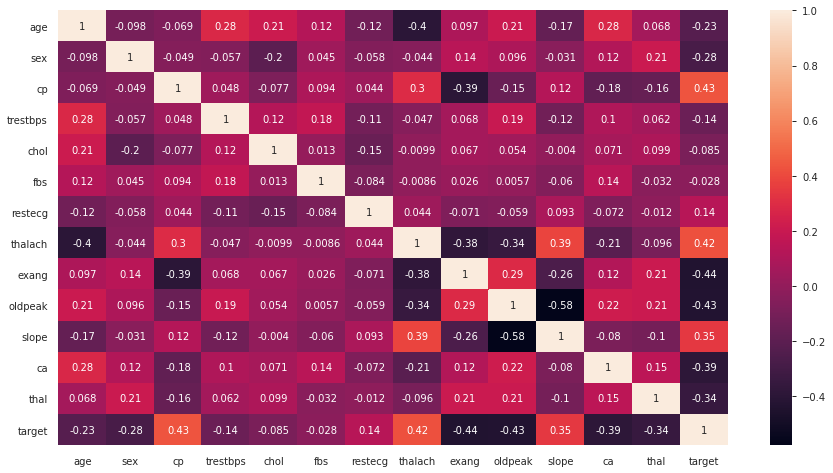

In [191]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
fig = plt.gcf()
fig.set_size_inches(15, 8)
sns.heatmap(df.corr(), annot = True)
plt.show()

* There is no features with more than 0.5, strong, correlation. 

**4.4 Distributions of continuous features**

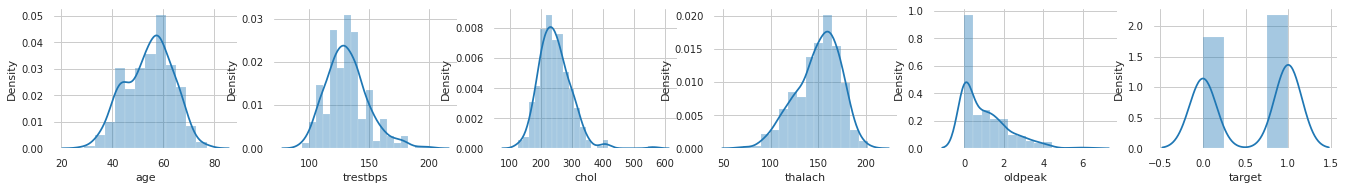

In [192]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']
number_of_columns = len(continuous_features)
number_of_rows = 5
plt.figure(figsize=(23, 18))

for i, f in enumerate(continuous_features):
    plt.subplot(number_of_rows + 1, number_of_columns, i + 1)
    sns.distplot(df[f], kde=True)



1.   Age, blood pressure, cholestoral level follow normal distribution.
2.   Around 60 has the highest possibility of having heart disease.



**4.5 Pair Plots**

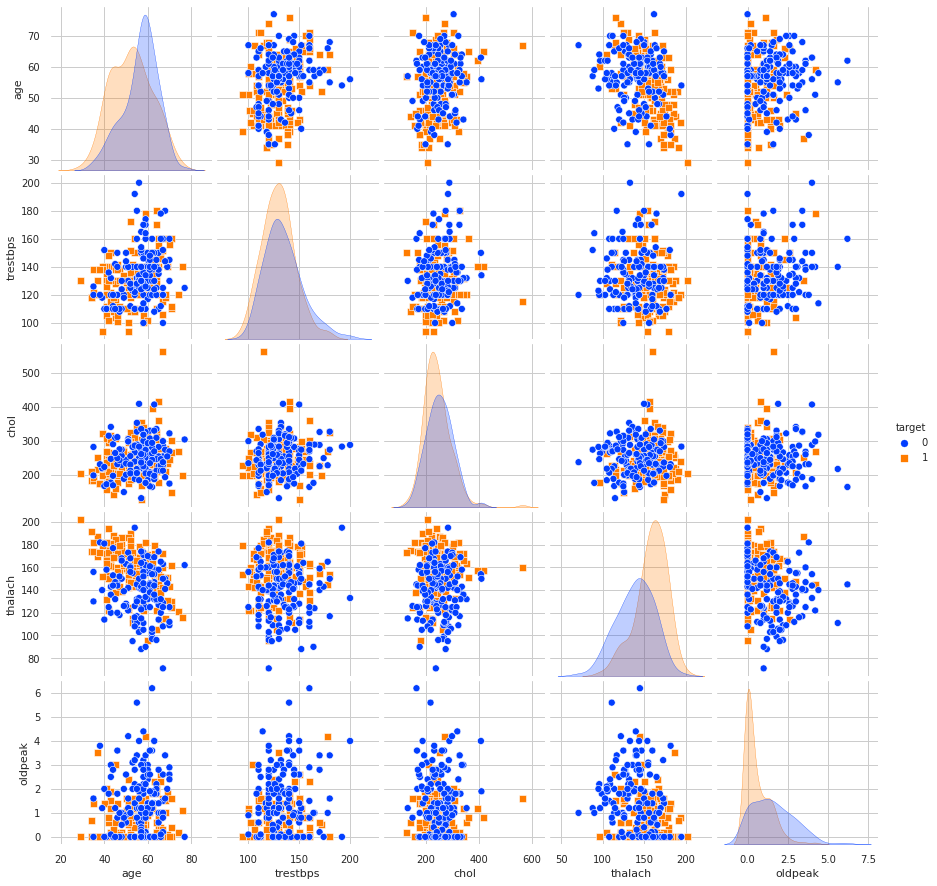

In [193]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
sns.pairplot(df, hue = 'target', markers=["o", "s"], vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], palette = sns.color_palette("bright",2))



*  There is no feature pair that seperates the data in two group. 


**5 Data Pre Processing**

**5.1 Extract Independent and Target Variables**


reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
*   Here the independet features will be extracted along with OneHotEncoding will be done to the nominal features cp, slope, thal and restecg.
*   The parameter drop_first = True as been set in order to avoid dummy variable trap after One hot encoding



In [240]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
#nominal_features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
 #      'exang', 'oldpeak', 'slope', 'ca', 'thal']
#x = pd.get_dummies(df.drop(['target'], axis = 1), columns = nominal_features, drop_first=True).values
#y = df.target.values
y = df["target"]
x = df.drop('target',axis=1)

**5.2 Split the Data into Train and Test set**

In [241]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

**5.3 Feature Scalling**

In [242]:
# reference from https://www.kaggle.com/pradeeshbm/heart-disease-prediction
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

**6 Build and Train the Model**

**6.1 Train the Model with Training Set**

eXtreme Gradient Boosting is used

In [243]:
# reference from https://www.kaggle.com/nareshbhat/heart-attack-prediction-using-different-ml-models
m = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(x_train, y_train)
xgb_predicted = xgb.predict(x_test)


**6.2 Alternative method (K-Nearest Neighbour and Support Vector Machine)**

K-Nearest Neighbour

In [244]:
# reference from https://www.kaggle.com/nareshbhat/heart-attack-prediction-using-different-ml-models
m2 = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
knn_predicted = knn.predict(x_test)


Support Vector Machine

In [245]:
m3 = 'Support Vector Classifier'
svc =  SVC(kernel='rbf', C=2)
svc.fit(x_train, y_train)
svc_predicted = svc.predict(x_test)


**7 Model Evaluation**

**7.1 Confusion Matrix**

In [246]:
# reference from https://www.kaggle.com/nareshbhat/heart-attack-prediction-using-different-ml-models
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confusion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of Extreme Gradient Boost:",round(xgb_acc_score*100, 2), "%"'\n')
print(classification_report(y_test,xgb_predicted))

confusion matrix
[[24  3]
 [ 3 31]]


Accuracy of Extreme Gradient Boost: 90.16 %

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        27
           1       0.91      0.91      0.91        34

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



K-Nearest Neighbour

In [247]:
# reference from https://www.kaggle.com/nareshbhat/heart-attack-prediction-using-different-ml-models
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",round(knn_acc_score*100,2), "%",'\n')
print(classification_report(y_test,knn_predicted))

confussion matrix
[[24  3]
 [ 4 30]]


Accuracy of K-NeighborsClassifier: 88.52 % 

              precision    recall  f1-score   support

           0       0.86      0.89      0.87        27
           1       0.91      0.88      0.90        34

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61



Support Vector Classifier

In [248]:
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of Support Vector Classifier:",round(svc_acc_score*100,2), "%",'\n')
print(classification_report(y_test,svc_predicted))

confussion matrix
[[23  4]
 [ 3 31]]


Accuracy of Support Vector Classifier: 88.52 % 

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.89      0.91      0.90        34

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61



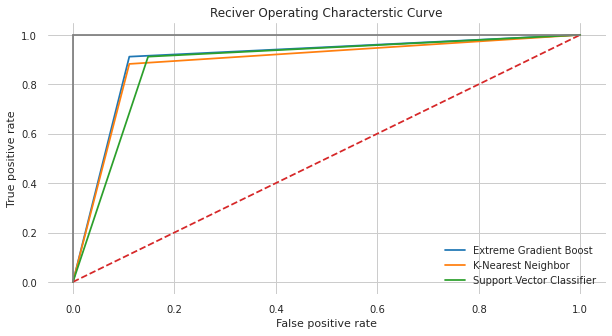

In [249]:
# reference from https://www.kaggle.com/nareshbhat/heart-attack-prediction-using-different-ml-models
xgb_false_positive_rate,xgb_true_positive_rate,xgb_threshold = roc_curve(y_test,xgb_predicted)
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(y_test,knn_predicted)
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svc_predicted)

sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='Extreme Gradient Boost')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

model accuracy comparison

In [250]:
# reference from https://www.kaggle.com/nareshbhat/heart-attack-prediction-using-different-ml-models
model_ev = pd.DataFrame({'Model': ['Extreme Gradient Boost',
                    'K-Nearest Neighbour','Support Vector Machine'], 'Accuracy (%)': [round(xgb_acc_score*100,2),round(knn_acc_score*100,2),round(svc_acc_score*100,2)]})
model_ev

,Model,Accuracy (%)
0,Extreme Gradient Boost,90.16
1,K-Nearest Neighbour,88.52
2,Support Vector Machine,88.52


10-Fold Cross Validation

In [282]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb, x_train, y_train, cv = 10)
print("Scores: ", scores)
print("Accuracy: ", round(scores.mean(), 2) * 100, "%")
print("Standard Deviation: +/-", scores.std())

Scores:  [0.76       0.8        0.91666667 0.75       0.875      0.83333333
 0.875      0.83333333 0.79166667 0.91666667]
Accuracy:  84.0 %
Standard Deviation: +/- 0.0570060912924614


**8 Model Optimization using Grid Search**

In [286]:
from sklearn.model_selection import GridSearchCV
parameters = {"learning_rate"    : [0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, ],
 "min_child_weight" : [ 1, 3, 5],
 "gamma"            : [ 0.1, 0.2 , 0.3, 0.4, 0.5 ],
 "colsample_bytree" : [ 0.2, 0.3, 0.4, 0.5] }
grid_search = GridSearchCV(estimator = xgb, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search = grid_search.fit(x_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Score: ", round(best_accuracy,2)*100, "%")
print("Best Params: ", best_parameters)

Best Score:  85.0 %
Best Params:  {'colsample_bytree': 0.3, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1}


The accuracy got improved by using grid search.